In [1]:
import os
import pandas as pd
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
torch.cuda.empty_cache()

In [109]:
import random

random_seed = 10

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [110]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train/images/'

In [111]:
def label(str):
    a = str.split('/')
    mask = a[-1]
    info = a[-2].split('_')
    info[-1] = int(info[-1])
    mask = mask.split('.')
    
    if mask[0] == 'mask1' or mask[0] == 'mask2'or mask[0] == 'mask3'or mask[0] == 'mask4'or mask[0] == 'mask5' :
        if info[1] == 'male':
            if info[-1] < 30:
                return 0
            elif 30<=info[-1] and info[-1]< 58:
                return 1
            else:
                return 2
        else:
            if info[-1] < 30:
                return 3
            elif 30<=info[-1] and info[-1]< 58:
                return 4
            else:
                return 5
    elif mask[0] == 'incorrect_mask':
        if info[1] == 'male':
            if info[-1] < 30:
                return 6
            elif 30<=info[-1] and info[-1]< 58:
                return 7
            else:
                return 8
        else:
            if info[-1] < 30:
                return 9
            elif 30<=info[-1] and info[-1]< 58:
                return 10
            else:
                return 11
            
    elif mask[0] == 'normal':
        if info[1] == 'male':
            if info[-1] < 30:
                return 12
            elif 30<=info[-1] and info[-1]< 58:
                return 13
            else:
                return 14
        else:
            if info[-1] < 30:
                return 15
            elif 30<=info[-1] and info[-1]< 58:
                return 16
            else:
                return 17
                    

In [112]:
def genderlabel(str):
    a = str.split('/')
    mask = a[-1]
    info = a[-2].split('_')
    info[-1] = int(info[-1])
    mask = mask.split('.')
    
    if info[1] == 'male':
        return 0
    else:
        return 1

In [113]:
df_gender = pd.read_csv('/opt/ml/input/data/train/train.csv')
gender_traindata = glob(train_dir+'*'+'/*')
gender_trainindex = []
for i in gender_traindata:
    gender_trainindex.append(genderlabel(i))

print(gender_traindata[1])
print(gender_trainindex[1])

/opt/ml/input/data/train/images/000523_female_Asian_51/normal.jpg
1


In [114]:
class genderTrainDataset(Dataset):
    def __init__(self,age_traindata,age_trainindex, age_transform):
        self.age_traindata = age_traindata
        self.age_trainindex = age_trainindex
        self.age_transform = age_transform
        
    def __getitem__(self,index):
        image = Image.open(self.age_traindata[index])
        label = self.age_trainindex[index]
        if self.age_transform:
            image = self.age_transform(image)
        return image, label    

    def __len__(self):
        return len(self.age_traindata)

In [115]:
gender_transform = transforms.Compose([
    Resize((224, 224), Image.BILINEAR),
    transforms.CenterCrop(130),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [116]:
g_X_train, g_X_eval, g_y_train, g_y_eval  = train_test_split(gender_traindata,gender_trainindex, test_size = 0.2)

In [117]:
g_trainset = genderTrainDataset(g_X_train,g_y_train, gender_transform)
g_evalset = genderTrainDataset(g_X_eval,g_y_eval, gender_transform)

g_train_loader = DataLoader(g_trainset, batch_size = 64 , num_workers = 2)
g_val_loader = DataLoader(g_evalset, batch_size = 64 , num_workers = 2)

In [118]:
NN = models.resnet50(pretrained=True) 
num_ftrs = NN.fc.in_features 
NN.fc = nn.Linear(num_ftrs, 2)
NN.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [119]:
import torchvision.models as models
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(NN.parameters(), momentum = 0.9, lr = 1e-3, weight_decay= 1e-4)

In [120]:
def gendertrain(epochs , train_loader, val_loader , model , criterion , optimizer):
    for epoch in range(epochs):
        model.train()
        
        loss_train_sum = 0
        acc_train_sum = 0
        
        for i , (img , target) in enumerate(tqdm(train_loader)):
            img = img.to(device)
            target = target.to(device, dtype=torch.int64)
            
            y_pred = model(img)
            loss = criterion(y_pred, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train_sum += loss
            acc_train_sum += (y_pred.argmax(1) == target).sum().item()/ 64

        loss_train_avg = loss_train_sum / len(train_loader)
        acc_train_avg = acc_train_sum / len(train_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_train_avg:.3f}] acc : [{acc_train_avg : .3f}]")
        
        
        model.eval()
        loss_val_sum = 0
        acc_val_sum = 0
        
        for i , (img , target) in enumerate(tqdm(val_loader)):
            img = img.to(device)
            target = target.to(device, dtype=torch.int64)
            
            with torch.no_grad():
                y_pred = model(img)
                loss = criterion(y_pred, target)
            
            loss_val_sum += loss
            acc_val_sum += (y_pred.argmax(1) == target).sum().item()/ 64
        
        loss_val_avg = loss_val_sum / len(val_loader)
        acc_val_avg = acc_val_sum / len(val_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_val_avg:.3f}] acc : [{acc_val_avg : .3f}]")
        

In [121]:
gendertrain(3 , g_train_loader , g_val_loader , NN, criterion , optimizer)

  0%|          | 0/60 [00:00<?, ?it/s]

 epoch:[1/3] cost:[0.181] acc : [ 0.924]


  0%|          | 0/237 [00:00<?, ?it/s]

 epoch:[1/3] cost:[0.068] acc : [ 0.964]


  0%|          | 0/60 [00:00<?, ?it/s]

 epoch:[2/3] cost:[0.033] acc : [ 0.988]


  0%|          | 0/237 [00:00<?, ?it/s]

 epoch:[2/3] cost:[0.045] acc : [ 0.969]


  0%|          | 0/60 [00:00<?, ?it/s]

 epoch:[3/3] cost:[0.009] acc : [ 0.995]


100%|██████████| 60/60 [00:11<00:00,  5.08it/s]

 epoch:[3/3] cost:[0.039] acc : [ 0.972]


In [122]:
plus = []

for data in os.listdir('/opt/ml/face_age'):
    for i in os.listdir('/opt/ml/face_age/'+data):
        plus.append(['/opt/ml/face_age/'+data+'/'+ i , data])
    
image_path= []
for i in range(len(plus)):
    plus[i][1] = int(plus[i][1])
    image_path.append(plus[i][0])

for i in range(len(plus)):
    print(plus[i])

['/opt/ml/face_age/066/4468.png', 66]
['/opt/ml/face_age/066/1744.png', 66]
['/opt/ml/face_age/066/7129.png', 66]
['/opt/ml/face_age/066/4167.png', 66]
['/opt/ml/face_age/066/5879.png', 66]
['/opt/ml/face_age/066/5759.png', 66]
['/opt/ml/face_age/066/2147.png', 66]
['/opt/ml/face_age/066/5028.png', 66]
['/opt/ml/face_age/066/416.png', 66]
['/opt/ml/face_age/066/5366.png', 66]
['/opt/ml/face_age/066/1618.png', 66]
['/opt/ml/face_age/066/6206.png', 66]
['/opt/ml/face_age/066/4492.png', 66]
['/opt/ml/face_age/066/6407.png', 66]
['/opt/ml/face_age/066/159.png', 66]
['/opt/ml/face_age/066/4638.png', 66]
['/opt/ml/face_age/066/972.png', 66]
['/opt/ml/face_age/066/8378.png', 66]
['/opt/ml/face_age/066/9724.png', 66]
['/opt/ml/face_age/066/4709.png', 66]
['/opt/ml/face_age/066/6007.png', 66]
['/opt/ml/face_age/066/4440.png', 66]
['/opt/ml/face_age/066/4043.png', 66]
['/opt/ml/face_age/066/4523.png', 66]
['/opt/ml/face_age/066/4684.png', 66]
['/opt/ml/face_age/066/4509.png', 66]
['/opt/ml/face_

In [123]:
class genderTestDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path = img_path
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_path[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_path)

In [124]:
dataset = genderTestDataset(image_path, gender_transform)

loader = DataLoader(
    dataset,
    shuffle=False
)


In [125]:
index = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = NN(images)
        pred = pred.argmax(dim=-1)
        index.append(pred)

100%|██████████| 3303/3303 [00:43<00:00, 76.12it/s]


In [126]:
def final_gender_label(tmp):
    gender = tmp[-1]
    age = tmp[-2]
    if gender == 0: #남자
        if 30<=age and age<58:
            return 13
        else:
            return 14
    else:
        if 30<=age and age<58:
            return 16
        else:
            return 17

In [127]:
for i in range(len(index)):
    plus[i].append(int(index[i]))

In [128]:
data = []
for i in plus:
    data.append(final_gender_label(i))

In [129]:
face_train_data = []

for i in range(len(plus)):
    face_train_data.append(plus[i][0])

In [130]:
df2 = pd.read_csv('/opt/ml/input/data/train/train.csv')
train_data = glob(train_dir+'*'+'/*')
train_index = []
for i in train_data:
    train_index.append(label(i))
print(len(train_data))
label(train_data[8])
df2.head()

18900


,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [131]:
print(len(train_index))
print(len(df2))

18900
2700


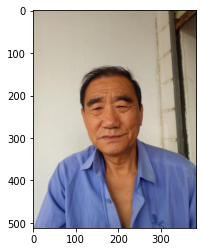

In [132]:
import matplotlib.pyplot as plt

x = Image.open(train_data[8])
plt.imshow(x)

In [133]:
label(train_data[1])

16

In [134]:
class TrainDataset(Dataset):
    def __init__(self,train_data,train_index, transform):
        self.train_data = train_data
        self.train_index = train_index
        self.transform = transform
        
    def __getitem__(self,index):
        image = Image.open(self.train_data[index])
        label = self.train_index[index]
        if self.transform:
            image = self.transform(image)
        return image, label    

    def __len__(self):
        return len(self.train_data)

In [135]:
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.kaiming_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
        
        
# model = models.resnet50(pretrained=True)
# num = model.fc.in_features
# classifier = nn.Sequential(nn.ReLU(),
#                            nn.Dropout(p=0.2),
#                            nn.Linear(num,18)
#                           )
# model.fc = classifier
# model.apply(init_weights)
# model.to(device)

In [136]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        
        
model = EfficientNet.from_pretrained('efficientnet-b3')
num = model._fc.in_features
classifier = nn.Sequential(
                           nn.Dropout(p=0.4),
                           nn.Linear(num,18),
                           nn.ReLU()
                          )
model._fc = classifier
model.apply(init_weights)
model.to(device)

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [137]:
Traintransform = transforms.Compose([
    Resize((224, 224), Image.BILINEAR),
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [138]:
train_data = train_data + face_train_data
train_index = train_index + data

In [139]:
print(len(train_data))

22203


In [140]:
X_train, X_eval, y_train, y_eval  = train_test_split(train_data,train_index, test_size = 0.2)

In [141]:
print(len(X_eval))

4441


In [142]:
a = np.array(train_data)
b = np.array(train_index)

In [143]:
c = pd.DataFrame(a,columns=['path'])
c['label'] = pd.DataFrame(b)
c

,path,label
0,/opt/ml/input/data/train/images/000523_female_...,4
1,/opt/ml/input/data/train/images/000523_female_...,16
2,/opt/ml/input/data/train/images/000523_female_...,4
3,/opt/ml/input/data/train/images/000523_female_...,4
4,/opt/ml/input/data/train/images/000523_female_...,10
...,...,...
22198,/opt/ml/face_age/063/6977.png,17
22199,/opt/ml/face_age/063/1195.png,14
22200,/opt/ml/face_age/063/8929.png,17
22201,/opt/ml/face_age/063/7142.png,14


<Figure size 432x216 with 0 Axes>

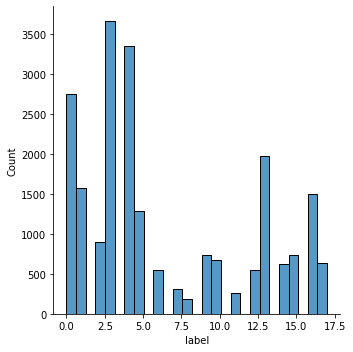

In [144]:
import seaborn as sns


plt.figure(figsize=(6, 3))
sns.displot(c, x="label")

In [145]:
def get_class_weight(label):
    label_unique, count = np.unique(label, return_counts=True)
    return [1-c/sum(count) for c in count]

result = get_class_weight(train_index)
result=torch.Tensor(result)
result = result.to(device)

In [146]:
trainset = TrainDataset(X_train,y_train, Traintransform)
evalset = TrainDataset(X_eval,y_eval, Traintransform)

train_loader = DataLoader(trainset, batch_size = 16 , num_workers = 4)
val_loader = DataLoader(evalset, batch_size = 16 , num_workers = 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


(150, 150, 3)

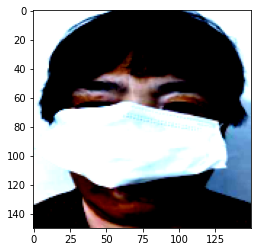

In [147]:
import matplotlib.pyplot as plt

x = evalset[55][0]
x = x.numpy().transpose(1,2,0)
plt.imshow(x)
print(evalset[55][1])
x.shape

In [148]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [154]:
import torchvision.models as models
criterion = FocalLoss(weight = result)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = 3e-4, weight_decay= 1e-5)
optimizer = optim.SGD(model.parameters(),momentum=0.9, lr = 3e-4, weight_decay= 1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

In [155]:
def train(epochs , train_loader, val_loader , model , criterion , optimizer,lr_scheduler):
    counter = 0
    best_val_acc = 0
    best_val_loss = np.inf
    patience = 5
    
    for epoch in range(epochs):
        model.train()
        
        loss_train_sum = 0
        acc_train_sum = 0
        
        for i , (img , target) in enumerate(tqdm(train_loader)):
            img = img.to(device)
            target = target.to(device, dtype=torch.int64)
            
            y_pred = model(img)
            loss = criterion(y_pred, target)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train_sum += loss
            acc_train_sum += (y_pred.argmax(1) == target).sum().item()/ 16

        loss_train_avg = loss_train_sum / len(train_loader)
        acc_train_avg = acc_train_sum / len(train_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_train_avg:.3f}] acc : [{acc_train_avg : .3f}]")
        
        
        model.eval()
        loss_val_sum = 0
        acc_val_sum = 0
        val_loss_items = []
        val_acc_items = []
        
        for i , (img , target) in enumerate(tqdm(val_loader)):
            img = img.to(device)
            target = target.to(device, dtype=torch.int64)
            
            with torch.no_grad():
                y_pred = model(img)
                loss = criterion(y_pred, target)
            
            loss_val_sum += loss
            acc_val_sum += (y_pred.argmax(1) == target).sum().item()/ 16
            val_loss_items.append(loss_val_sum)
            val_acc_items.append(acc_val_sum)
        
        
        loss_val_avg = loss_val_sum / len(val_loader)
        acc_val_avg = acc_val_sum / len(val_loader)
        
        if loss_val_avg < best_val_loss:
            best_val_loss = loss_val_avg
        if acc_val_avg > best_val_acc:
            print("New best model for val accuracy! saving the model..")
            best_val_acc = acc_val_avg
            counter = 0
        else:
            counter += 1
        # Callback2: patience 횟수 동안 성능 향상이 없을 경우 학습을 종료시킵니다.
        if counter > patience:
            print("Early Stopping...")
            break
            
        print(f" epoch:[{epoch+1}/{epochs}] eval_cost:[{loss_val_avg:.3f}] eval_acc : [{acc_val_avg : .3f}]")
        
        lr_scheduler.step()


In [156]:
train(5 , train_loader , val_loader , model, criterion ,optimizer,lr_scheduler)

  0%|          | 0/278 [00:00<?, ?it/s]

 epoch:[1/5] cost:[0.004] acc : [ 0.995]


  0%|          | 0/1111 [00:00<?, ?it/s]

New best model for val accuracy! saving the model..
 epoch:[1/5] eval_cost:[0.169] eval_acc : [ 0.927]


  0%|          | 0/278 [00:00<?, ?it/s]

 epoch:[2/5] cost:[0.003] acc : [ 0.996]


  0%|          | 0/1111 [00:00<?, ?it/s]

 epoch:[2/5] eval_cost:[0.173] eval_acc : [ 0.926]


100%|██████████| 1111/1111 [02:28<00:00,  7.47it/s]


 epoch:[3/5] cost:[0.003] acc : [ 0.996]


  0%|          | 0/1111 [00:00<?, ?it/s]

 epoch:[3/5] eval_cost:[0.169] eval_acc : [ 0.925]


  0%|          | 0/278 [00:00<?, ?it/s]

 epoch:[4/5] cost:[0.003] acc : [ 0.996]


  0%|          | 0/1111 [00:00<?, ?it/s]

 epoch:[4/5] eval_cost:[0.169] eval_acc : [ 0.924]


  0%|          | 0/278 [00:00<?, ?it/s]

 epoch:[5/5] cost:[0.003] acc : [ 0.996]


100%|██████████| 278/278 [00:10<00:00, 26.87it/s]


 epoch:[5/5] eval_cost:[0.170] eval_acc : [ 0.927]


In [157]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [158]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((224, 224), Image.BILINEAR),
    transforms.CenterCrop(150),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

100%|██████████| 12600/12600 [06:52<00:00, 30.55it/s]

test inference is done!
